In [2]:
library(mgsub)
library(gghalves)
library(reshape2)
library(tidyverse)
library(RColorBrewer)
library(boot)
library(corrplot)
library(asbio) # partial R squared 
library(lsa)

In [3]:
lowerTriangle <- function(m){
  return(m[lower.tri(m)])
}

cosine_matrix = function(raw_data){
    # rel*rel matrix caculated by cosine similarity
    n <- nrow(raw_data)  # raw_data is an n x n matrix, 159*dimensions
    # create an empty matrix to store cosine similarity
    raw_data_cor <- matrix(0, nrow = n, ncol = n)
    colnames(raw_data_cor) <- rownames(raw_data)
    rownames(raw_data_cor) <- rownames(raw_data)
    # calculate the cosine similarity of the upper triangular part
    for (i in 1:(n - 1)) {
        for (j in (i + 1):n) {
            cosine_value <- cosine(as.numeric(raw_data[i, ]), as.numeric(raw_data[j, ]))
            raw_data_cor[i, j] <- cosine_value
        }
    }
    # symmetrically fill the cosine similarity in the lower triangular part
    raw_data_cor <- raw_data_cor + t(raw_data_cor)

    # set the diagonal to 1
    diag(raw_data_cor) <- 1
    return(raw_data_cor)
}

# Import data

In [7]:
# FAVEE model: favee
favee_258r_pc=read.csv('human_rating_data/human_model/CHN_258r_favee.csv',row.names=1) 
rels_order_modern_258r = rownames(favee_258r_pc)

rels_order_ancient_120r = read.csv('human_rating_data/ancient_modern_map_120r.csv')$'对应的现代人际关系'
favee_120r_pc = favee_258r_pc[rels_order_ancient_120r,]
# single dimension model: pcsdv
ns <- length(favee_120r_pc)
pcsdv_120r = data.frame(matrix(nrow = 120*119/2, ncol=5))
colnames(pcsdv_120r) = colnames(favee_120r_pc)
for (i in 1:5){
    pcsdv_120r[[i]] = c(-dist(favee_120r_pc[,i])) # take proximities on each dimension
}

In [8]:
bert_emb_ancient = read.csv('sim_bert_embedding/ancient/q3.2_bert_embedding_data/MASK_embedding_output.csv',
                   row.names = 1, check.names = FALSE)
bert_emb_ancient = bert_emb_ancient[rels_order_ancient_120r,rels_order_ancient_120r]
bert_ancient_120r_array = lowerTriangle(bert_emb_ancient)

bert_emb_modern = read.csv('sim_bert_embedding/modern/q3.1_bert_embedding_data/MASK_embedding_output.csv',
                   row.names = 1, check.names = FALSE)
bert_emb_modern = bert_emb_modern[rels_order_modern_258r,rels_order_modern_258r]
bert_modern_258r_array = lowerTriangle(bert_emb_modern)

bert_emb_modern_120r =  bert_emb_modern[rels_order_ancient_120r,rels_order_ancient_120r]
bert_modern_120r_array = lowerTriangle(bert_emb_modern_120r)

# Linear regression

In [9]:
compute_partial_R2 = function(model) {
    predictors = colnames(model)[-c(6)]
    results <- list()  
    lm.without <- update(model, ~. -Formality.human)
    results[['Formality']] <- partial.R2(lm.without, model)
    lm.without <- update(model, ~. -Activeness.human)
    results[['Activeness']] <- partial.R2(lm.without, model)    
    lm.without <- update(model, ~. -Valence.human)
    results[['Valence']] <- partial.R2(lm.without, model) 
    lm.without <- update(model, ~. -Exchange.human)
    results[['Exchange']] <- partial.R2(lm.without, model) 
    lm.without <- update(model, ~. -Equality.human)
    results[['Equality']] <- partial.R2(lm.without, model) 
    return(results) 
}

## bert embedding

In [11]:
pcsdv_120r_y = cbind(pcsdv_120r,bert_modern_120r_array)
colnames(pcsdv_120r_y)[6] = 'Modern.bert'
pcsdv_120r_y_scaled.m = data.frame(scale(pcsdv_120r_y))
modern_model = lm(data=pcsdv_120r_y_scaled.m,
                  Modern.bert~Formality.human+Activeness.human+Valence.human+
                  Exchange.human+Equality.human)
compute_partial_R2(modern_model)


pcsdv_120r_y = cbind(pcsdv_120r,bert_ancient_120r_array)
colnames(pcsdv_120r_y)[6] = 'Ancient.bert'
pcsdv_120r_y_scaled.a = data.frame(scale(pcsdv_120r_y))
ancient_model = lm(data=pcsdv_120r_y_scaled.a,
                  Ancient.bert~Formality.human+Activeness.human+Valence.human+
                  Exchange.human+Equality.human)
compute_partial_R2(ancient_model)

$Formality
[1] 0.07355156

$Activeness
[1] 0.02807876

$Valence
[1] 0.06471033

$Exchange
[1] 0.05799826

$Equality
[1] 0.03883426

$Formality
[1] 0.02425012

$Activeness
[1] 0.01611285

$Valence
[1] 0.03315631

$Exchange
[1] 0.02985894

$Equality
[1] 0.03312188

In [12]:
partial_r = rbind(data.frame(compute_partial_R2(ancient_model)),
      data.frame(compute_partial_R2(modern_model)))
rownames(partial_r) = c('ancient','modern')

partial_r_prop = partial_r / rowSums(partial_r)
partial_r_prop$'epoch' = rownames(partial_r_prop)

within_prop_across = melt(partial_r_prop, id.vars = c('epoch'))
colnames(within_prop_across)[2] = 'dim'
colnames(within_prop_across)[3] = 'prop'
within_prop_across$'dim' = factor(within_prop_across$'dim', 
                                   levels=c('Formality','Activeness','Valence','Exchange','Equality'))
within_prop_across$'epoch' = factor(within_prop_across$'epoch',levels = c('modern','ancient'))

within_prop_segment = partial_r_prop[,-c(6)]
within_prop_segment = data.frame(t(within_prop_segment))
within_prop_segment$'dim' = rownames(within_prop_segment)
within_prop_segment$'dim' = factor(within_prop_segment$'dim', 
                                   levels=c('Formality','Activeness','Valence','Exchange','Equality'))

In [13]:
my.color = c('human'="#F2997A",'modern'="#a17db4",'ancient'="#9DCD82")

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."
Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


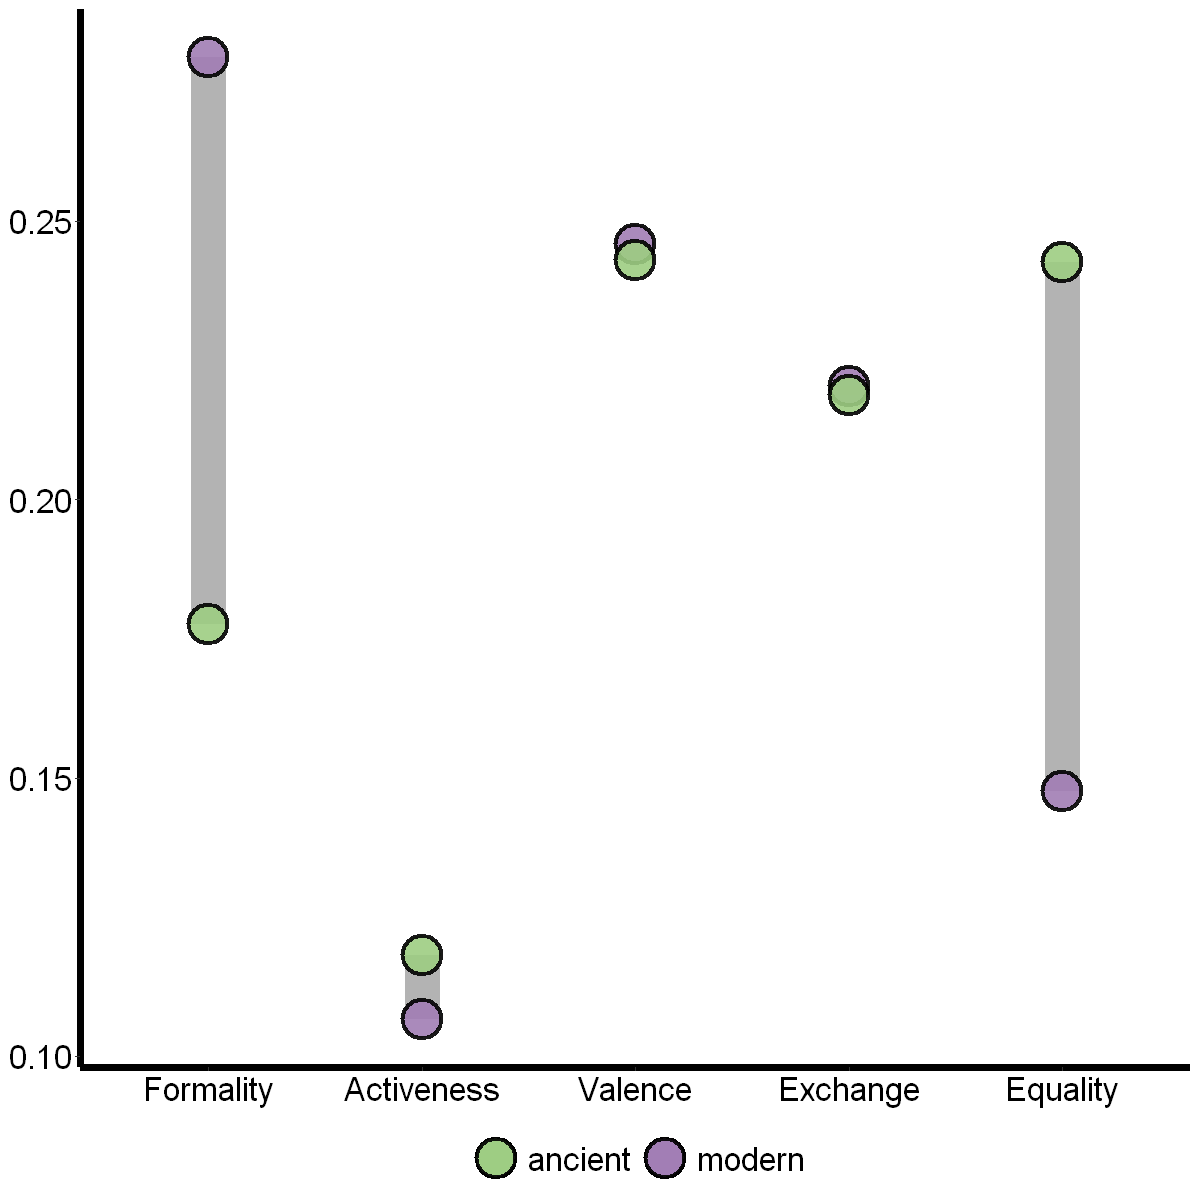

In [14]:
options(repr.plot.width=10,repr.plot.height=10)
ggplot() +
             
# plot RSA correlation
geom_segment(data=within_prop_segment,aes(x=dim,xend=dim,y=ancient,yend=modern),
             size=10,alpha=0.3)+
geom_point(data=within_prop_across[within_prop_across$'epoch'=='modern',], 
           aes(x=dim, y=prop,fill=epoch),size=10,alpha=0.9,shape=21,stroke=2)+
geom_point(data=within_prop_across[within_prop_across$'epoch'=='ancient',], 
           aes(x=dim, y=prop,fill=epoch),size=10,alpha=0.9,shape=21,stroke=2)+

scale_color_manual(values=my.color)+
scale_fill_manual(values=my.color)+
theme_classic()+
#coord_flip()+
theme(axis.title = element_blank(),
      #axis.text.y = element_blank(),
      axis.text = element_text(size=20,color="black"),
      axis.line = element_line(linetype=1,color="black",size=2),    
      legend.title = element_blank(),
      legend.text = element_text(size=20),
      legend.position = 'bottom'
     )

In [15]:
png("output_graph/cultural_evolution.png", bg="transparent",
    family = 'sans',units='in',width=10,height=10,res=300)
options(repr.plot.width=10,repr.plot.height=10)
ggplot() +
             
# plot RSA correlation
geom_segment(data=within_prop_segment,aes(x=dim,xend=dim,y=ancient,yend=modern),
             size=10,alpha=0.3)+
geom_point(data=within_prop_across[within_prop_across$'epoch'=='modern',], 
           aes(x=dim, y=prop,fill=epoch),size=10,alpha=0.9,shape=21,stroke=2)+
geom_point(data=within_prop_across[within_prop_across$'epoch'=='ancient',], 
           aes(x=dim, y=prop,fill=epoch),size=10,alpha=0.9,shape=21,stroke=2)+

scale_color_manual(values=my.color)+
scale_fill_manual(values=my.color)+
theme_classic()+
#coord_flip()+
theme(axis.title = element_blank(),
      #axis.text.y = element_blank(),
      axis.text = element_text(size=20,color="black"),
      axis.line = element_line(linetype=1,color="black",size=2),    
      legend.title = element_blank(),
      legend.text = element_text(size=20),
      legend.position = 'bottom'
     )
dev.off()

png 
  2